In [404]:
import pandas as pd
from datetime import datetime
from pprint import pprint

In [405]:
#optional settings
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 3)

In [406]:
#define function that will gather data from csv files, join together into a single DataFrame
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        #parse_dates-list of lists. e.g. If [[1, 3]] -> combine columns 1 and 3 and parse as a single date column.
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs,ignore_index = True)
        
week_nums = [191102, 191109, 191116,191123,191130,191207,191214,191221,191228,200104,200111,200118,200125,200201,200208,200215,200222,200229]
turnstiles_df = get_data(week_nums)

In [ ]:
#use the get_date function for files in week_nums and store that in variable 'turnsiles_df'
week_nums = [191102, 191109, 191116,191123,191130,191207,191214,191221,191228,200104,200111,200118,200125,200201,200208,200215,200222,200229]
turnstiles_df = get_data(week_nums)

In [407]:
# Clear whitespace, reindex the columns and then view the columns
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df.reindex()
turnstiles_df.columns

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [409]:
#Add two new columns towards the end of the DataFrame
turnstiles_df["STATION_LINE"] = turnstiles_df.STATION + " " + turnstiles_df.LINENAME
turnstiles_df["WEEKDAY"] = turnstiles_df['DATE_TIME'].dt.day_name()

In [410]:
#For each field find number of distinct records
nunique_d = {}
for x in turnstiles_df.columns:
    nunique_d[x] = turnstiles_df[x].nunique()
pprint(nunique_d)

{'C/A': 748,
 'DATE': 126,
 'DATE_TIME': 245569,
 'DESC': 2,
 'DIVISION': 6,
 'ENTRIES': 2530450,
 'EXITS': 2327277,
 'LINENAME': 114,
 'SCP': 227,
 'STATION': 378,
 'STATION_LINE': 478,
 'TIME': 70246,
 'UNIT': 469,
 'WEEKDAY': 7}


In [426]:
#A few preliminary thoughts after having looked at head, tail, sample, unique data etc.
# 1. STATION_LINE is a better identifier for particular stations, so it is better to use that column for grouping
#    rather than just grouping STATION or LINE data on its own
# 2. DATE is a better identifier for grouping purposes as well
# 3. Before we can group on STATION_LINE and DATE, all the adjustments and data cleaning needs to be done at a
#    granular level (i.e we need to initially group the data in a way when turnstile unit info. is shown rather
#    than STATION_LINE info. as a whole)
# 4. There are 476 unique STATION_LINE in the November Dataset, and we need to find the most popular ones

#Below code returns the names of 476 unique STATION_LINEs, while I haven't gone through the list for accuracy
#it seems complete (verified using google "how many subway stops in NYC?"). No further analysis needed for 
#completeness, accuracy, consistency etc. is needed on STATION LINEs at this time for two reason. The first is
#that we a reasonably certain of the most popular stations through general knowledge. The second is that we are
#looking for the minimum viable product and cannot be spending to much time on any one attribute.


for x in sorted(turnstiles_df.STATION_LINE.unique()):
    print(x)

1 AV L
103 ST 1
103 ST 6
103 ST BC
103 ST-CORONA 7
104 ST A
104 ST JZ
110 ST 6
111 ST 7
111 ST A
111 ST J
116 ST 23
116 ST 6
116 ST BC
116 ST-COLUMBIA 1
121 ST JZ
125 ST 1
125 ST 23
125 ST 456
125 ST ACBD
135 ST 23
135 ST BC
137 ST CITY COL 1
138/GRAND CONC 45
14 ST 123FLM
14 ST ACEL
14 ST FLM123
14 ST-UNION SQ 456LNQRW
14 ST-UNION SQ LNQR456W
145 ST 1
145 ST 3
145 ST ABCD
149/GRAND CONC 245
14TH STREET 1
15 ST-PROSPECT FG
155 ST BD
155 ST C
157 ST 1
161/YANKEE STAD 4BD
161/YANKEE STAD BD4
163 ST-AMSTERDM C
167 ST 4
167 ST BD
168 ST 1AC
168 ST AC1
169 ST F
170 ST 4
170 ST BD
174 ST 25
174-175 STS BD
175 ST A
176 ST 4
18 AV D
18 AV F
18 AV N
18 ST 1
181 ST 1
181 ST A
182-183 STS BD
183 ST 4
190 ST A
191 ST 1
2 AV F
20 AV D
20 AV N
207 ST 1
21 ST G
21 ST-QNSBRIDGE F
215 ST 1
219 ST 25
225 ST 25
23 ST 1
23 ST 6
23 ST CE
23 ST FM
23 ST NRW
231 ST 1
233 ST 25
238 ST 1
25 AV D
25 ST R
28 ST 1
28 ST 6
28 ST NRW
3 AV 138 ST 6
3 AV L
3 AV-149 ST 25
30 AV NQW
33 ST 6
33 ST-RAWSON ST 7
34 ST-HERA

In [287]:
#A mask is similar to a where clause in SQL and will basically allow us to filter the data so that we can look
#at the subset of the overall population to identify discrepancies and eliminate them

#In the below case we are looking at a very particular STATION, UNIT and SUBUNIT  
mask = ((turnstiles_df["STATION"] == "23 ST") & 
(turnstiles_df["UNIT"] == "R276") & 
(turnstiles_df["SCP"] == "00-00-01") & 
(turnstiles_df["STATION"] == "VERNON-JACKSON") &
(turnstiles_df["DATE_TIME"].dt.date == datetime(2016, 9, 16).date()))
turnstiles_df[mask].head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION_LINE,WEEKDAY


In [427]:
# Not really helpful at the moment but we will revisit

# print(turnstiles_df.ENTRIES.count(), turnstiles_df.EXITS.count())
# print(turnstiles_df.ENTRIES.mean(), turnstiles_df.EXITS.mean())
# print(turnstiles_df.ENTRIES.std(), turnstiles_df.EXITS.std())
# print(turnstiles_df.ENTRIES.max(), turnstiles_df.EXITS.max())
# print(turnstiles_df.ENTRIES.min(), turnstiles_df.EXITS.min())
len(turnstiles_df)

3708428

In [428]:
#turnstiles_df.rename(columns = {'DAY':'WEEKDAY'}, inplace = True

#taking a quick look at the data to decide next steps
turnstiles_df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION_LINE,WEEKDAY
0,2019-10-26 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,00:00:00,REGULAR,7247322,2455491,59 ST NQR456W,Saturday
1,2019-10-26 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,04:00:00,REGULAR,7247336,2455499,59 ST NQR456W,Saturday
2,2019-10-26 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,08:00:00,REGULAR,7247351,2455532,59 ST NQR456W,Saturday
3,2019-10-26 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,12:00:00,REGULAR,7247463,2455623,59 ST NQR456W,Saturday
4,2019-10-26 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,16:00:00,REGULAR,7247755,2455679,59 ST NQR456W,Saturday


In [429]:
#Observation 2: The following code shows that the count of rows are different for each station. A station with more UNITS and SUBUNITS will have more SUBUNITS being tracked..as seen below
#Grand Centeral has the most a mount of data entries as it has the most turnstiles that are reporting back
#if we divide row count of each station by the turnstiles in each station, we quotient should represent the total
#clock-ins by each turnstiles. We we then divde that by the number of days, it will return the daily clock-in
(turnstiles_df
 .groupby(["STATION_LINE"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False))

,STATION_LINE,ENTRIES
313,GRD CNTRL-42 ST 4567S,55966
303,FULTON ST 2345ACJZ,47530
94,34 ST-PENN STA ACE,42416
90,34 ST-HERALD SQ BDFMNQRW,41770
103,42 ST-PORT AUTH ACENQRS1237W,33219
...,...,...
197,BAYCHESTER AV 5,2256
227,BRONX PARK EAST 25,2255
409,PELHAM PKWY 5,2252
443,SUTTER AV L,1512


In [430]:
# Sanity Check to verify that "C/A BOOTH", "TURNSTILE UNIT", "TURNSTILE SUBUNIT", "STATION", "DATE_TIME" is unique
(turnstiles_df
 .groupby(["STATION_LINE", "C/A", "UNIT", "SCP", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values(["ENTRIES","STATION_LINE"], ascending=(False, False))).head(50)

,STATION_LINE,C/A,UNIT,SCP,DATE_TIME,ENTRIES
3137330,PARK PLACE 23ACE,R115,R029,00-00-00,2020-01-22 07:00:00,2
2973940,MT EDEN AV 4,R285,R308,00-00-00,2019-11-02 00:00:00,2
2973942,MT EDEN AV 4,R285,R308,00-00-00,2019-11-02 08:00:00,2
2973943,MT EDEN AV 4,R285,R308,00-00-00,2019-11-02 12:00:00,2
2973944,MT EDEN AV 4,R285,R308,00-00-00,2019-11-02 16:00:00,2
2973945,MT EDEN AV 4,R285,R308,00-00-00,2019-11-02 20:00:00,2
2973946,MT EDEN AV 4,R285,R308,00-00-00,2019-11-03 00:00:00,2
2973947,MT EDEN AV 4,R285,R308,00-00-00,2019-11-03 03:00:00,2
2973948,MT EDEN AV 4,R285,R308,00-00-00,2019-11-03 07:00:00,2
2973949,MT EDEN AV 4,R285,R308,00-00-00,2019-11-03 11:00:00,2


In [433]:
#"For MT EDEN AV 4", we have many duplicates, we should check why:
# mask = (turnstiles_df["STATION_LINE"] == "GRD CNTRL-42 ST 4567S")
# turnstiles_df[mask].sort_values("DESC").head(50)
#turnstiles_df = turnstiles_df[~turnstiles_df['DESC'].isin(["RECOVR AUD"])]
#turnstiles_df.reindex()
#Observation 3 - the rowcount of our dataframe decreaesd from 1029721 to 1025534 when I removed the RECOVR AUD
len(turnstiles_df)

3691618

In [434]:
# turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")
turnstiles_df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION_LINE,WEEKDAY
0,2019-10-26 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,00:00:00,REGULAR,7247322,2455491,59 ST NQR456W,Saturday
1,2019-10-26 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,04:00:00,REGULAR,7247336,2455499,59 ST NQR456W,Saturday
2,2019-10-26 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,08:00:00,REGULAR,7247351,2455532,59 ST NQR456W,Saturday
3,2019-10-26 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,12:00:00,REGULAR,7247463,2455623,59 ST NQR456W,Saturday
4,2019-10-26 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/26/2019,16:00:00,REGULAR,7247755,2455679,59 ST NQR456W,Saturday


In [436]:
#Grouped DataFrame to get the daily numbers for each station
turnstiles_daily = (turnstiles_df
                        .groupby(["STATION_LINE", "C/A", "UNIT", "SCP", "DATE"],as_index=False)
                        .ENTRIES.first())

In [437]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["STATION_LINE","C/A", "UNIT","STATION_LINE"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

In [438]:
turnstiles_daily.head()

,STATION_LINE,C/A,UNIT,SCP,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,1 AV L,H007,R248,00-00-00,01/01/2020,15313601,NaN,nan
1,1 AV L,H007,R248,00-00-00,01/02/2020,15314633,01/01/2020,"15,313,601.0"
2,1 AV L,H007,R248,00-00-00,01/03/2020,15318008,01/02/2020,"15,314,633.0"
3,1 AV L,H007,R248,00-00-00,01/04/2020,15321494,01/03/2020,"15,318,008.0"
4,1 AV L,H007,R248,00-00-00,01/05/2020,15323654,01/04/2020,"15,321,494.0"


In [439]:
# Drop the rows for the earliest date in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
turnsiles.

In [388]:
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION_LINE,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1366,A011,R080,01-03-00,57 ST-7 AV NQRW,10/27/2019,885795902,10/26/2019,"885,796,390.0"
1367,A011,R080,01-03-00,57 ST-7 AV NQRW,10/28/2019,885795527,10/27/2019,"885,795,902.0"
1368,A011,R080,01-03-00,57 ST-7 AV NQRW,10/29/2019,885794581,10/28/2019,"885,795,527.0"
1369,A011,R080,01-03-00,57 ST-7 AV NQRW,10/30/2019,885793619,10/29/2019,"885,794,581.0"
1370,A011,R080,01-03-00,57 ST-7 AV NQRW,10/31/2019,885792629,10/30/2019,"885,793,619.0"


In [389]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

505 3846725.0
871 2152170.0
163 2209769.0
326 6844908.0
265 10392208.0
2214 6026439.0
2292 19783215.0
458752 117440512.0
14 1841376.0
75 6624746.0
669 2460428.0
67122970 103605.0
233 67122970.0
235398341 9934.0
83886083 117440614.0
82 2209128.0
31260679 48392.0
18 3511766.0
756 9852707.0
1 134218317.0
2580 2885384.0
15749521 3953152.0
3953156 15763173.0
39238070 15742628.0
15763179 39256787.0
10314 5196852.0
5197465 1004928.0
352351971 1425810.0
748 2242013.0
16730529 453031810.0
1761654126 6924207.0
1560341984 6151913.0
2046772863 8817079.0
1114883 3429015.0
1011 12274281.0


In [390]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION_LINE,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST NQR456W,10/27/2019,7248310,10/26/2019,"7,247,322.0",988.0
2,A002,R051,02-00-00,59 ST NQR456W,10/28/2019,7248888,10/27/2019,"7,248,310.0",578.0
3,A002,R051,02-00-00,59 ST NQR456W,10/29/2019,7250393,10/28/2019,"7,248,888.0","1,505.0"
4,A002,R051,02-00-00,59 ST NQR456W,10/30/2019,7251873,10/29/2019,"7,250,393.0","1,480.0"
5,A002,R051,02-00-00,59 ST NQR456W,10/31/2019,7253334,10/30/2019,"7,251,873.0","1,461.0"


In [402]:
# then get top 10 stations by daily volume 
# (sum across all days is a reasonable way to define this)
top10_stations = \
    (turnstiles_daily.groupby(['STATION_LINE'])['DAILY_ENTRIES'].sum()
                   .reset_index()
                   .sort_values(by='DAILY_ENTRIES',ascending=False).head(20))

top10_stations

,STATION_LINE,DAILY_ENTRIES
311,GRD CNTRL-42 ST 4567S,"5,043,814.0"
89,34 ST-HERALD SQ BDFMNQRW,"3,782,148.0"
402,PATH NEW WTC 1,"3,590,840.0"
102,42 ST-PORT AUTH ACENQRS1237W,"2,675,696.0"
93,34 ST-PENN STA ACE,"2,459,972.0"
458,W 4 ST-WASH SQ ABCDEFM,"2,112,594.0"
28,14 ST-UNION SQ LNQR456W,"2,079,853.0"
446,TIMES SQ-42 ST 1237ACENQRSW,"1,885,700.0"
123,59 ST COLUMBUS ABCD1,"1,864,276.0"
106,47-50 STS ROCK BDFM,"1,798,017.0"


/Users/rajkumarkatta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  """Entry point for launching an IPython kernel.


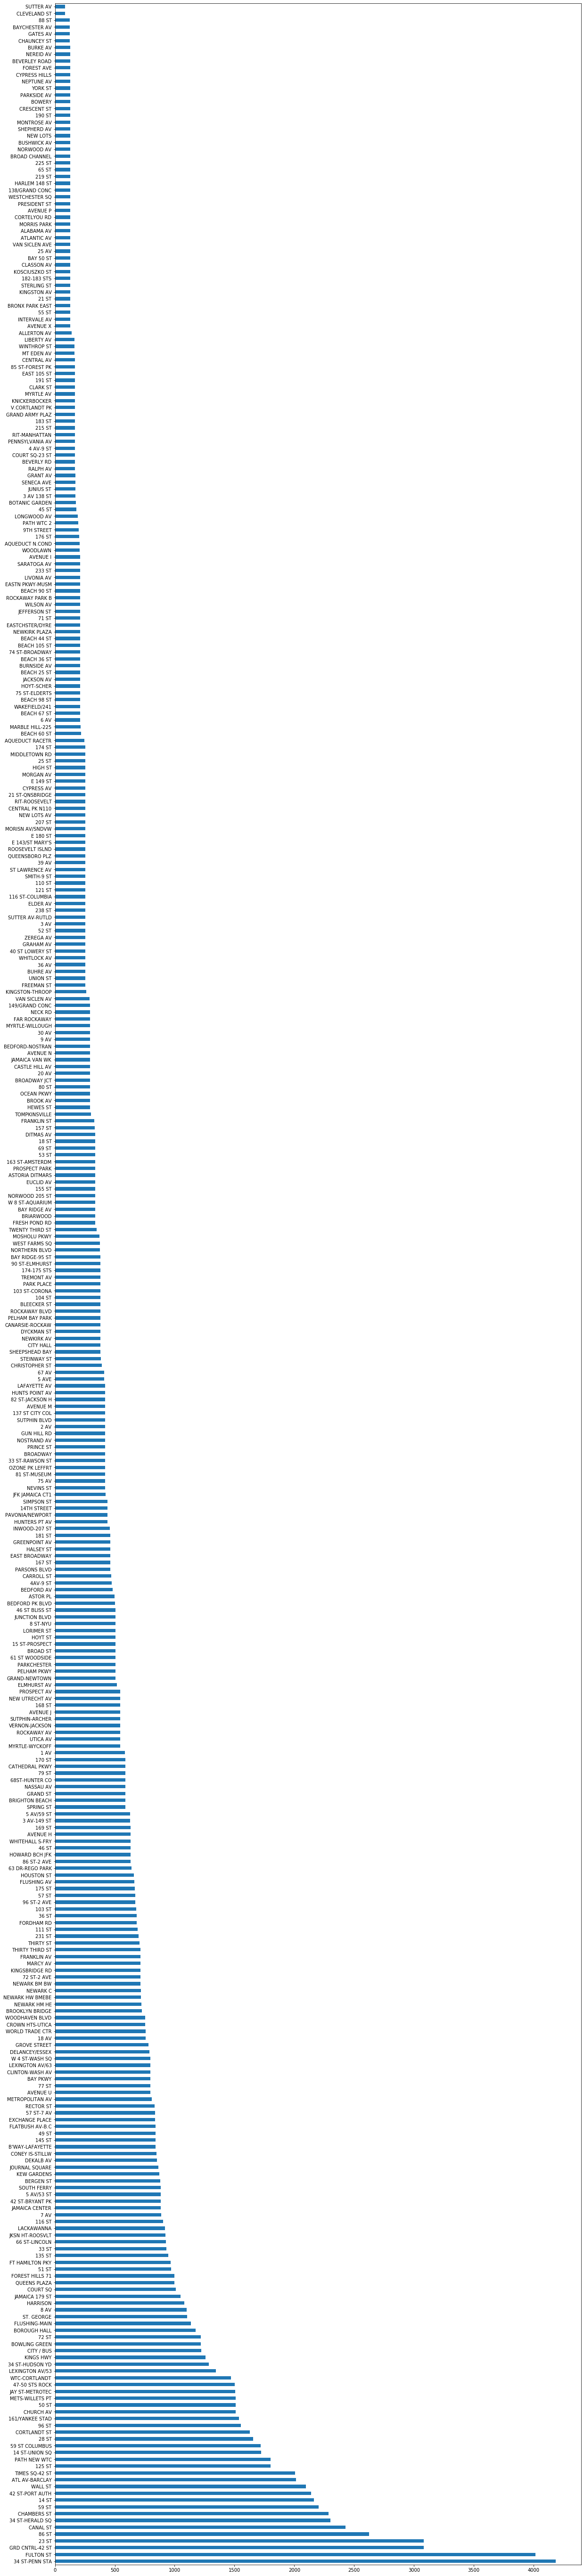

In [379]:

turnstiles_daily.DAILY_E.value_counts().plot('barh',figsize = (20,100))

In [105]:
df.STATION.nunique()

377

In [147]:
df.STATION.unique()

array(['59 ST', '5 AV/59 ST', '57 ST-7 AV', '49 ST', 'TIMES SQ-42 ST',
       '34 ST-HERALD SQ', '28 ST', '23 ST', '14 ST-UNION SQ', '8 ST-NYU',
       'PRINCE ST', 'CANAL ST', 'CITY HALL', 'CORTLANDT ST', 'RECTOR ST',
       'WHITEHALL S-FRY', 'DELANCEY/ESSEX', 'BOWERY', 'CHAMBERS ST',
       'FULTON ST', 'BROAD ST', '7 AV', 'PARK PLACE', 'BOTANIC GARDEN',
       'PROSPECT PARK', 'PARKSIDE AV', 'CHURCH AV', 'BEVERLEY ROAD',
       'CORTELYOU RD', 'NEWKIRK PLAZA', 'AVENUE H', 'AVENUE J',
       'AVENUE M', 'KINGS HWY', 'AVENUE U', 'NECK RD', 'SHEEPSHEAD BAY',
       'BRIGHTON BEACH', 'OCEAN PKWY', 'BOROUGH HALL', 'JAY ST-METROTEC',
       'DEKALB AV', 'ATL AV-BARCLAY', 'UNION ST', '4AV-9 ST',
       'PROSPECT AV', '25 ST', '36 ST', '45 ST', '53 ST', 'BAY RIDGE AV',
       '77 ST', '86 ST', 'BAY RIDGE-95 ST', '8 AV', 'FT HAMILTON PKY',
       'NEW UTRECHT AV', '18 AV', '20 AV', 'BAY PKWY', '9 AV', '50 ST',
       '55 ST', '71 ST', '79 ST', '25 AV', 'BAY 50 ST', 'CONEY IS-STILLW',
      

In [111]:
df.groupby([
    'STATION',
    'DATE',
    'TIME'
])[['ENTRIES', 'EXITS']].mean().max()

ENTRIES    1.151e+09
EXITS      6.893e+08
dtype: float64

In [121]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs)
        
week_nums = [191102, 191109, 191116,191123,191130]
turnstiles_df = get_data(week_nums)

In [122]:
turnstiles_df = turnstiles_df.reset_index(drop=True)
turnstiles_df.head()
turnstiles_df.shape

(1029721, 12)

In [123]:
turnstiles_df.DATE.value_counts().sort_index()

10/26/2019    29229
10/27/2019    29338
10/28/2019    29426
10/29/2019    29832
10/30/2019    29319
              ...  
11/25/2019    29962
11/26/2019    29235
11/27/2019    29655
11/28/2019    29265
11/29/2019    29156
Name: DATE, Length: 35, dtype: int64

In [126]:
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(50)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
844651,R285,R308,00-00-00,MT EDEN AV,2019-11-02 20:00:00,2
803396,R240,R047,00-03-04,GRD CNTRL-42 ST,2019-11-27 08:00:00,2
844674,R285,R308,00-00-00,MT EDEN AV,2019-11-06 15:00:00,2
844675,R285,R308,00-00-00,MT EDEN AV,2019-11-06 19:00:00,2
844676,R285,R308,00-00-00,MT EDEN AV,2019-11-06 23:00:00,2
...,...,...,...,...,...,...
844668,R285,R308,00-00-00,MT EDEN AV,2019-11-05 15:00:00,2
844669,R285,R308,00-00-00,MT EDEN AV,2019-11-05 19:00:00,2
803395,R240,R047,00-03-04,GRD CNTRL-42 ST,2019-11-27 04:00:00,2
844664,R285,R308,00-00-00,MT EDEN AV,2019-11-04 23:00:00,2


In [144]:
(turnstiles_df.groupby(["C/A", "STATION"]).ENTRIES.count().reset_index()).sort_values("ENTRIES",ascending=False)

,C/A,STATION,ENTRIES
457,PTH22,PATH NEW WTC,8959
708,R610,ATL AV-BARCLAY,5632
440,PTH02,HARRISON,5391
445,PTH07,CITY / BUS,4873
571,R238,GRD CNTRL-42 ST,4642
...,...,...,...
145,H037,SUTTER AV,420
362,N414,FLUSHING AV,420
162,J022,CLEVELAND ST,420
44,A085,BROAD ST,210
